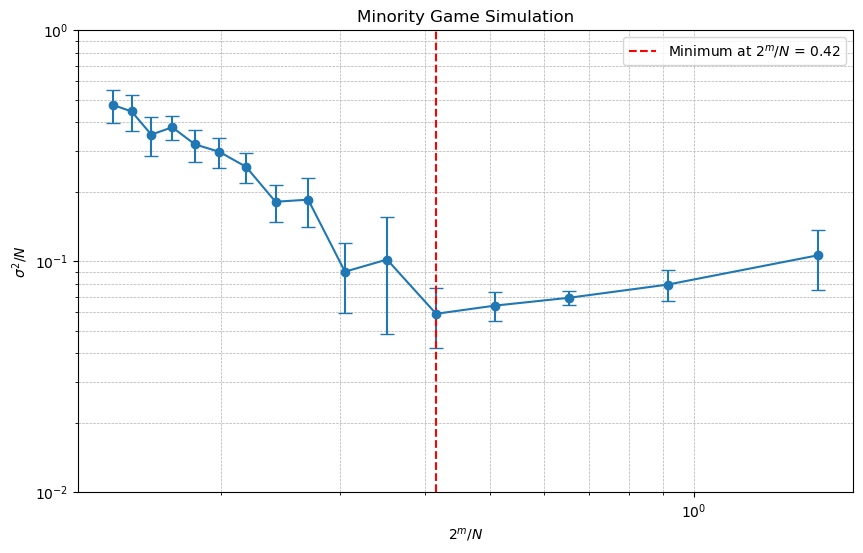

In [46]:
import numpy as np
import random
import matplotlib.pyplot as plt

def generate_strategy_label(dim):
    """
    Generate a random strategy label (integer) for an agent.
    The strategy label represents the binary output for all 2^m states.
    """
    return random.randint(0, 2**dim - 1)

def strategy_response(strategy_label, state):
    """
    Get the response of a strategy for a specific state using its label.
    Convert the strategy label back to binary and extract the response for the given state.
    """
    return (strategy_label >> state) & 1

def update_state(current_state, new_bit, dim):
    """
    Update the historical state by shifting left and adding the new bit (mod 2^m).
    """
    return ((current_state << 1) | new_bit) % dim

def simulate_minority_game(m, N, s, iteq, iter_num, nsam):
    """
    Simulate the Minority Game with dynamic strategy generation using labels.
    """
    dim = 2**m  # Total number of states
    var_list = []

    for sample in range(nsam):
        # Step 1: Each agent randomly selects s strategy labels
        agent_strategies = [
            [generate_strategy_label(dim) for _ in range(s)]
            for _ in range(N)
        ]
        
        # Step 2: Initialize virtual and real scores
        virtual_scores = np.zeros((N, s))  # Virtual scores for each strategy of each agent
        real_scores = np.zeros(N)  # Real scores for each agent
        current_state = 0  # Initial state
        buyers_record = []

        for t in range(iter_num):
            # Step 3: Each agent selects the best strategy (randomly if tied)
            chosen_strategies = []
            for i in range(N):
                best_score = max(virtual_scores[i])
                best_indices = [j for j in range(s) if virtual_scores[i][j] == best_score]
                chosen_index = random.choice(best_indices)
                chosen_strategies.append(chosen_index)
            
            # Compute the actions of all agents
            actions = []
            for i in range(N):
                strategy_label = agent_strategies[i][chosen_strategies[i]]
                action = strategy_response(strategy_label, current_state)
                actions.append(action)
            
            buyers = sum(actions)  # Count buyers (actions = 1)
            buyers_record.append(buyers)
            excess_demand = 2 * buyers - N  # Compute excess demand

            # Update virtual scores and real scores
            for i in range(N):
                for j in range(s):
                    strategy_label = agent_strategies[i][j]
                    prediction = strategy_response(strategy_label, current_state)
                    virtual_scores[i][j] -= (1 if prediction == 1 else -1) * excess_demand / N
                
                # Update real scores
                chosen_label = agent_strategies[i][chosen_strategies[i]]
                chosen_prediction = strategy_response(chosen_label, current_state)
                real_scores[i] -= (1 if chosen_prediction == 1 else -1) * excess_demand / N
            
            # Update the historical state
            minority_sign = 1 if buyers < (N / 2) else 0
            current_state = update_state(current_state, minority_sign, dim)
        
        # Collect statistics after the warm-up phase
        var_list.append(np.var(buyers_record[iteq:], ddof=1))
    
    # Return mean and standard deviation of variance across samples
    return np.mean(var_list), np.std(var_list)

# Main simulation parameters
m = 5
s = 2
iteq = 200
iter_num = 1000
nsam = 10

# Range of N values
N_values = np.linspace(21, 231, 16, dtype=int)
mean_variances = []
std_variances = []

for N in N_values:
    mean_var, std_var = simulate_minority_game(m, N, s, iteq, iter_num, nsam)
    mean_variances.append(mean_var)
    std_variances.append(std_var)

# Compute x and y for plotting
x_values = [(2**m) / N for N in N_values]
y_values = [mean_var / N for mean_var, N in zip(mean_variances, N_values)]

# Find the minimum value and corresponding x
min_index = np.argmin(y_values)
min_x = x_values[min_index]
min_y = y_values[min_index]

# Plot the results on a logarithmic scale
plt.figure(figsize=(10, 6))
plt.errorbar(x_values, y_values, yerr=[std / N for std, N in zip(std_variances, N_values)], fmt='o-', capsize=5)
plt.axvline(x=min_x, color='red', linestyle='--', label=f'Minimum at $2^m/N$ = {min_x:.2f}')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-2, 1e0)  # Expand the y-axis range
plt.xlabel(r'$2^m / N$')
plt.ylabel(r'$\sigma^2 / N$')
plt.title('Minority Game Simulation')
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

